In [1]:
# %load /home/jonathan/.ipython/profile_default/startup/01-setup.py
# start up settings for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# use plt.style.available() to check out available styles
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000

# to avoid have warnings from chained assignments
pd.options.mode.chained_assignment = None

In [2]:
import json
import itertools as itls

## Preprocessing + preliminary analysis
For the ICPM paper, only need to identify a few examples where the algorithms having significantly different performances to support the idea that applying machine learning techniques would be good. Also another part of the contributions is in exploring all the surrounding problems in building a good enough predictive model by looking into constructing the appropriate training and testing datasets. This requires looking into sampling techniques, and perhaps hierarchy of random variables. 

### Find examples where the algorithms have significantly different performances

#### Load in data

In [3]:
TRACE_STATS_ENRICHED_FILENAME = 'trace-stats-enriched.csv'
TRACE_STATS_FILENAME = 'trace-stats.csv'
CONFIGS_JSON_FILENAME = 'configs.json'
REPLAY_ID = 'replay_id'
ALIGNMENT_FILENAME = 'alignment_filename'

# things to ignore from configs
OUTFILE_KEY = 'outFile'
RESULTDIR_KEY = 'resultDir'
LOGPATH_KEY = 'logPath'
MODELPATH_KEY = 'modelPath'
TO_IGNORE_KEY_LIST = [
    OUTFILE_KEY, 
    RESULTDIR_KEY,
    LOGPATH_KEY,
    MODELPATH_KEY
]

def get_caseids(alignment_fpath):
    with open(alignment_fpath, 'r') as f:
        lines = f.readlines()
        caseids = lines[5]
        caseid_list = caseids.split(',')
        caseid_list = list(map(lambda cid: cid.strip(), caseid_list))
    return caseid_list
        

def mono_read_trace_stats(replay_id, replay_dirpath):
    trace_stats_fpath = os.path.join(replay_dirpath, TRACE_STATS_ENRICHED_FILENAME)
    configs_fpath = os.path.join(replay_dirpath, CONFIGS_JSON_FILENAME)
    alignment_dirpath = os.path.join(replay_dirpath, 'alignment')
    
    with open(configs_fpath, 'r') as f:
        configs_dict = json.load(f)
        
    for key in TO_IGNORE_KEY_LIST:
        del configs_dict[key]
        
    trace_stats_df = pd.read_csv(trace_stats_fpath)
    trace_stats_df[REPLAY_ID] = replay_id
    
    for key, item in configs_dict.items():
        trace_stats_df[key] = item
    
    alignment_caseid_list = []
    
    for fname in os.listdir(alignment_dirpath):
        alignment_fpath = os.path.join(alignment_dirpath, fname)
        alignment_id = fname.replace('.csv', '')
        caseid_list = get_caseids(alignment_fpath)
        alignment_caseid_list_i = zip(itls.repeat(alignment_id), caseid_list)
        alignment_caseid_list = alignment_caseid_list + list(alignment_caseid_list_i)
    
    alignment_caseid_df = pd.DataFrame(alignment_caseid_list, columns=[ALIGNMENT_FILENAME, 'SP label'])
    trace_stats_df = trace_stats_df.merge(alignment_caseid_df, on='SP label', suffixes=('', ''))
    
    return trace_stats_df


def reco_read_trace_stats(replay_id, replay_dirpath):
    trace_stats_fpath = os.path.join(replay_dirpath, TRACE_STATS_FILENAME)
    configs_fpath = os.path.join(replay_dirpath, CONFIGS_JSON_FILENAME)
    alignment_dirpath = os.path.join(replay_dirpath, 'alignments')
    
    with open(configs_fpath, 'r') as f:
        configs_dict = json.load(f)
        
    for key in TO_IGNORE_KEY_LIST:
        del configs_dict[key]
        
    trace_stats_df = pd.read_csv(trace_stats_fpath)
    trace_stats_df[REPLAY_ID] = replay_id
    
    for key, item in configs_dict.items():
        trace_stats_df[key] = item
    
    alignment_caseid_list = []
    
    for fname in os.listdir(alignment_dirpath):
        alignment_fpath = os.path.join(alignment_dirpath, fname)
        alignment_id = fname.replace('.csv', '')
        caseid_list = get_caseids(alignment_fpath)
        alignment_caseid_list_i = zip(itls.repeat(alignment_id), caseid_list)
        alignment_caseid_list = alignment_caseid_list + list(alignment_caseid_list_i)
    
    alignment_caseid_df = pd.DataFrame(alignment_caseid_list, columns=[ALIGNMENT_FILENAME, 'SP label'])
    trace_stats_df = trace_stats_df.merge(alignment_caseid_df, on='SP label', suffixes=('', ''))
        
    return trace_stats_df

In [4]:
# testing
mono_basedir = '../../results-agg/clst_2018_12/2018-12-06_18_12_52_669712_mono-astar'
reco_basedir = '../../results-agg/clst_2018_12/2018-12-16_04:51:57:866056_BPI2018-net1-nILP-astar-sese_25-score-strict'

mono_stats_df_list = []
reco_stats_df_list = []

for d in os.listdir(mono_basedir):
    replay_dirpath = os.path.join(mono_basedir, d)
    if not os.path.isdir(replay_dirpath):
        continue
        
    trace_stats_df = mono_read_trace_stats(d, replay_dirpath)
    mono_stats_df_list.append(trace_stats_df)
    
for d in os.listdir(reco_basedir):
    replay_dirpath = os.path.join(reco_basedir, d)
    if not os.path.isdir(replay_dirpath):
        continue
        
    trace_stats_df = reco_read_trace_stats(d, replay_dirpath)
    reco_stats_df_list.append(trace_stats_df)
    
mono_stats_df = pd.concat(mono_stats_df_list, axis=0)
reco_stats_df = pd.concat(reco_stats_df_list, axis=0)

In [5]:
mono_stats_df.columns

Index(['SP label', 'Exit code for alignment', 'Length of the alignment found',
       'Length of the orignal trace', 'Places in the synchronous product',
       'Transtions in the synchronous product', 'Cost of the alignment',
       'Transitions fired', 'Markings polled from queue',
       'Markings added to closed set', 'Markings queued', 'Markings reached',
       'Heuristics computed', 'Heuristics estimated', 'Heuristics derived',
       'Maximum queue length (elts)', 'Maximum queue capacity (elts)',
       'Maximum capacity visited set (elts)',
       'Approximate peak memory used (kb)', 'Time to compute alignment (us)',
       'Time to compute heuristics (us)', 'Time to setup algorithm (us)',
       'Total Time including setup (us)',
       'Number of splits when splitting marking', 'Log move cost of alignment',
       'Model move cost of alignment', 'Synchronous move cost of alignment',
       'Pre-processing time (us)', 'Size of the constraintset',
       'Number of times repla

In [6]:
reco_stats_df.columns

Index(['SP label', 'Transitions fired', 'total Memory (MB)',
       'Pre-processing time (us)', 'Heuristics derived',
       'Time to compute heuristics (us)', 'Exit code for alignment',
       'Markings queued', 'Size of the constraintset',
       'Maximum queue length (elts)', 'Time to compute alignment (us)',
       'Markings polled from queue', 'Time to setup algorithm (us)',
       'Total Time including setup (us)', 'Log move cost of alignment',
       'Maximum capacity visited set (elts)', 'Cost of the alignment',
       'Heuristics estimated', 'Number of times replay was restarted',
       'max Memory (MB)', 'Heuristics computed',
       'Model move cost of alignment', 'Synchronous move cost of alignment',
       'Number of splits when splitting marking', 'Markings reached',
       'Maximum queue capacity (elts)', 'Markings added to closed set',
       'merged_alignment_cost', 'merged_alignment_length',
       'merged_alignment_log_trace_length',
       'merged_alignment_model_t

''

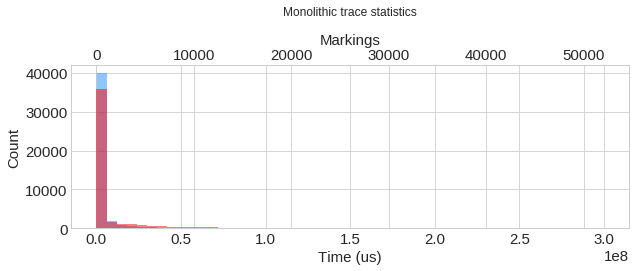

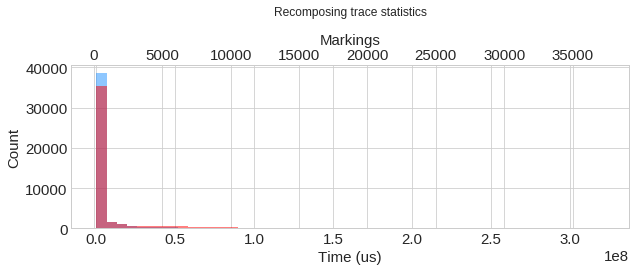

In [7]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.hist(mono_stats_df['Total Time including setup (us)'], bins=50, alpha=0.5, color='dodgerblue')
ax_twin = ax.twiny()
ax_twin.hist(mono_stats_df['Markings polled from queue'], bins=50, alpha=0.5, color='red')

ax.set_ylabel('Count')
ax.set_xlabel('Time (us)')
ax_twin.set_xlabel('Markings')
# ax_twin.hist(mono_stats_df['Markings queued'], bins=50, alpha=0.5, color='purple')

ax.set_title('Monolithic trace statistics', pad=50)

fig, ax = plt.subplots(figsize=(10, 3))

ax.hist(reco_stats_df['Total Time including setup (us)'], bins=50, alpha=0.5, color='dodgerblue')
ax_twin = ax.twiny()
ax_twin.hist(reco_stats_df['Markings polled from queue'], bins=50, alpha=0.5, color='r')

ax.set_ylabel('Count')
ax.set_xlabel('Time (us)')
ax_twin.set_xlabel('Markings')

ax.set_title('Recomposing trace statistics', pad=50)
;

### Check time distribution between A* and LP

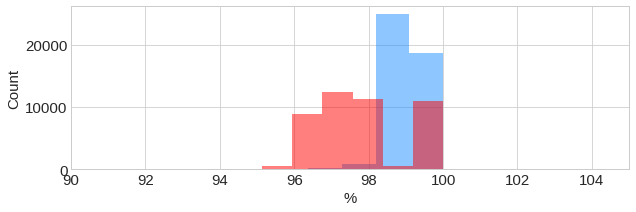

In [8]:
mono_stats_df['align_time_perc'] = mono_stats_df['Time to compute alignment (us)'] / mono_stats_df['Total Time including setup (us)'] * 100.
reco_stats_df['align_time_perc'] = reco_stats_df['Time to compute alignment (us)'] / reco_stats_df['Total Time including setup (us)'] * 100.

fig, ax = plt.subplots(figsize=(10, 3))

ax.hist(mono_stats_df['align_time_perc'], bins=100, alpha=0.5, color='dodgerblue')
ax.hist(reco_stats_df['align_time_perc'], bins=100, alpha=0.5, color='red')

ax.set_xlim([90, 105])

ax.set_ylabel('Count')
ax.set_xlabel('%');

Heuristic computation takes up a very smaller (< 5%) of the total computation time.

In [9]:
cols_perf_diff = [
    'Total Time including setup (us)',
    'Markings polled from queue',
    'Markings queued',
    'Markings added to closed set',
    'Markings reached',
    'SP label', 
    'replay_id'
]

mono_perf_df = mono_stats_df[cols_perf_diff]
reco_perf_df = reco_stats_df[cols_perf_diff]

# check that SP label and replay_id are sufficient as unique ids
assert mono_stats_df[['SP label', 'replay_id']].duplicated().any() == False
assert reco_stats_df[['SP label', 'replay_id']].duplicated().any() == False

perf_df = mono_perf_df.merge(reco_perf_df, on=['SP label', 'replay_id'], suffixes=('_mono', '_reco'))
perf_df['time_diff'] = perf_df['Total Time including setup (us)_mono'] - perf_df['Total Time including setup (us)_reco']
perf_df['polled_diff'] = perf_df['Markings polled from queue_mono'] - perf_df['Markings polled from queue_reco']
perf_df['queued_diff'] = perf_df['Markings queued_mono'] - perf_df['Markings queued_reco']
perf_df['closed_diff'] = perf_df['Markings added to closed set_mono'] - perf_df['Markings added to closed set_reco']
perf_df['reached_diff'] = perf_df['Markings reached_mono'] - perf_df['Markings reached_reco']

In [10]:
reco_better_time = perf_df[(perf_df['time_diff'] > 0)].count()[0]
reco_better_polled = perf_df[(perf_df['polled_diff'] > 0)].count()[0]
reco_better_queued = perf_df[(perf_df['queued_diff'] > 0)].count()[0]
reco_better_closed = perf_df[(perf_df['closed_diff'] > 0)].count()[0]
reco_better_reached = perf_df[(perf_df['reached_diff'] > 0)].count()[0]

print('{} traces where recomposing beat monolithic in time'.format(reco_better_time))
print('{} traces where recomposing beat monolithic in polled markings'.format(reco_better_polled))
print('{} traces where recomposing beat monolithic in queued markings'.format(reco_better_queued))
print('{} traces where recomposing beat monolithic in closed markings'.format(reco_better_closed))
print('{} traces where recomposing beat monolithic in reached markings'.format(reco_better_reached))

1458 traces where recomposing beat monolithic in time
1216 traces where recomposing beat monolithic in polled markings
911 traces where recomposing beat monolithic in queued markings
1071 traces where recomposing beat monolithic in closed markings
623 traces where recomposing beat monolithic in reached markings


In [11]:
# compute the precision and recall of using polled_diff as a proxy to time_diff
def int_list_to_str(l):
    return list(map(
        lambda p: '-'.join(map(lambda num: str(num), p)), l
    ))

def compute_f1_against_time(colname):
    reco_better_time_ids = perf_df.loc[(perf_df['time_diff'] > 0), ['SP label', 'replay_id']].values
    reco_better_marking_ids = perf_df.loc[(perf_df[colname] > 0), ['SP label', 'replay_id']].values
    
    reco_better_time_ids = int_list_to_str(reco_better_time_ids)
    reco_better_marking_ids = int_list_to_str(reco_better_marking_ids)
    
    TP = list(filter(lambda _id: _id in reco_better_marking_ids, reco_better_time_ids))
    
    precision = len(TP) / len(reco_better_marking_ids)
    recall = len(TP) / len(reco_better_time_ids)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return f1, precision, recall

f1, precision, recall = compute_f1_against_time('polled_diff')

print('Polled diff')
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1: {:.2f}'.format(f1))

f1, precision, recall = compute_f1_against_time('queued_diff')

print('\nQueued diff')
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1: {:.2f}'.format(f1))

f1, precision, recall = compute_f1_against_time('closed_diff')

print('\nClosed diff')
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1: {:.2f}'.format(f1))

f1, precision, recall = compute_f1_against_time('reached_diff')

print('\nReached diff')
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1: {:.2f}'.format(f1))

Polled diff
Precision: 0.81
Recall: 0.68
F1: 0.74

Queued diff
Precision: 0.81
Recall: 0.50
F1: 0.62

Closed diff
Precision: 0.80
Recall: 0.59
F1: 0.68

Reached diff
Precision: 0.74
Recall: 0.32
F1: 0.44


In [12]:
def get_trace(df, label, replay_id):
    return df[
        (df['SP label'] == label)&
        (df['replay_id'] == replay_id)
    ]

In [13]:
reco_best = perf_df[(perf_df['time_diff'] == perf_df['time_diff'].max())]
reco_best_times = reco_best[['Total Time including setup (us)_reco', 'Total Time including setup (us)_mono']] / 1000000
reco_best_times_diff = (perf_df['time_diff'] / 1000000).max()
reco_best_times_reco = reco_best_times['Total Time including setup (us)_reco'].values[0]
reco_best_times_mono = reco_best_times['Total Time including setup (us)_mono'].values[0]

print('Best recomposing performance diff: {:.2f}s'.format(reco_best_times_diff))
print('Recomposing time: {:.2f}s'.format(reco_best_times_reco))
print('Monolithic time: {:.2f}s'.format(reco_best_times_mono))

reco_best_caseid = reco_best['SP label'].values[0]
reco_best_replay_id = reco_best['replay_id'].values[0]

print()

reco_best_trace = get_trace(mono_stats_df, reco_best_caseid, reco_best_replay_id)
reco_best_trace_reco = get_trace(reco_stats_df, reco_best_caseid, reco_best_replay_id)

Best recomposing performance diff: 87.15s
Recomposing time: 13.57s
Monolithic time: 100.73s



In [14]:
reco_best_trace[['replay_id', 'SP label', 'n_log_move', 'n_model_move', ALIGNMENT_FILENAME]]

,replay_id,SP label,n_log_move,n_model_move,alignment_filename
181,0,3655,12.0,12.0,1


In [15]:
reco_best_trace_reco[['replay_id', 'SP label', 'merged_alignment_n_log_move', 'merged_alignment_n_model_move', 'n_replay_iter', ALIGNMENT_FILENAME]]

,replay_id,SP label,merged_alignment_n_log_move,merged_alignment_n_model_move,n_replay_iter,alignment_filename
438,0,3655,12.0,12.0,2,1


In [16]:
mono_best = perf_df[(perf_df['time_diff'] == perf_df['time_diff'].min())]
mono_best_times = mono_best[['Total Time including setup (us)_reco', 'Total Time including setup (us)_mono']] / 1000000
mono_best_times_diff = (perf_df['time_diff'] / 1000000).min()
mono_best_times_reco = mono_best_times['Total Time including setup (us)_reco'].values[0]
mono_best_times_mono = mono_best_times['Total Time including setup (us)_mono'].values[0]

print('Best monolithic performance diff: {:.2f}s'.format(mono_best_times_diff))
print('Recomposing time: {:.2f}s'.format(mono_best_times_reco))
print('Monolithic time: {:.2f}s'.format(mono_best_times_mono))

mono_best_caseid = mono_best['SP label'].values[0]
mono_best_replay_id = mono_best['replay_id'].values[0]

mono_best_trace = get_trace(mono_stats_df, mono_best_caseid, mono_best_replay_id)
mono_best_trace_reco = get_trace(reco_stats_df, mono_best_caseid, mono_best_replay_id)

Best monolithic performance diff: -174.23s
Recomposing time: 300.74s
Monolithic time: 126.51s


In [17]:
mono_best_trace[['replay_id', 'SP label', 'n_log_move', 'n_model_move', ALIGNMENT_FILENAME]]

,replay_id,SP label,n_log_move,n_model_move,alignment_filename
4864,15,4865,69.0,56.0,78


In [18]:
mono_best_trace_reco[['replay_id', 'SP label', 'merged_alignment_n_log_move', 'merged_alignment_n_model_move', 'n_replay_iter', ALIGNMENT_FILENAME]]

,replay_id,SP label,merged_alignment_n_log_move,merged_alignment_n_model_move,n_replay_iter,alignment_filename
4295,15,4865,-1.0,-1.0,2,4987


In [19]:
reco_stats_df[(reco_stats_df[ALIGNMENT_FILENAME] == '4987')]

,SP label,Transitions fired,total Memory (MB),Pre-processing time (us),Heuristics derived,Time to compute heuristics (us),Exit code for alignment,Markings queued,Size of the constraintset,Maximum queue length (elts),...,localDuration,initDecompFile,moveOnLogCosts,logCreationStrategy,initialSplits,debug,log,intervalRelative,alignment_filename,align_time_perc
3794,4413,371,95744,1120,114,15764,1,386,0,10,...,300000,../data/synthetic/BPI2018/net1/decomposition/net1.sese_25,10,Strict exclude by conflicts,0,stats,net1-60-10-l5000,100,4987,97.756823
4295,4865,52364,104425,1565,4843,298371220,35,35535,0,510,...,300000,../data/synthetic/BPI2018/net1/decomposition/net1.sese_25,10,Strict exclude by conflicts,0,stats,net1-60-60-l5000,100,4987,99.999679
52,1045,357,94243,1269,109,16169,1,372,0,9,...,300000,../data/synthetic/BPI2018/net1/decomposition/net1.sese_25,10,Strict exclude by conflicts,0,stats,net1-10-60-l5000,100,4987,97.415642
2213,2991,369,94854,1541,117,15554,1,393,0,17,...,300000,../data/synthetic/BPI2018/net1/decomposition/net1.sese_25,10,Strict exclude by conflicts,0,stats,net1-0-0-l1000,100,4987,96.887526
2213,2991,369,92826,1813,117,15188,1,393,0,17,...,300000,../data/synthetic/BPI2018/net1/decomposition/net1.sese_25,10,Strict exclude by conflicts,0,stats,net1-0-0-l5000,100,4987,97.805244
3734,436,368,93450,1165,115,15150,1,386,0,22,...,300000,../data/synthetic/BPI2018/net1/decomposition/net1.sese_25,10,Strict exclude by conflicts,0,stats,net1-10-10-l5000,100,4987,97.355496
